In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import random
import os
import warnings

# 모든 경고 무시
warnings.filterwarnings("ignore")

def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
seed_everything()

In [22]:
data_path = "/home/workspace/LGamiers/"
df_train = pd.read_csv(data_path + "train.csv") # 학습용 데이터
df_test = pd.read_csv(data_path + "submission.csv")

In [23]:
use_feature = [feature for feature in df_train.columns if df_train[feature].isnull().sum()<35000]

In [24]:
categorical = [feature for feature in use_feature  if df_train[feature].dtype=='O']
numeric = [f for f in use_feature  if f not in categorical]

In [25]:
df_train = df_train[use_feature]
df_test = df_test[use_feature]

def same_word_detect(df, categorical_list):
    for feature in categorical_list:
        df[feature] = df[feature].str.lower()
        # 특수문자를 대체 문자열 지정
        replacement = {'/': '', 
                       '-':'', 
                       '_':'', 
                       ' ':'', 
                       '~':'',
                       '&':'',
                       '.':'',
                       ',':''}
        # replace() 함수를 사용하여 특수 문자 대체
        df[feature].replace(replacement, inplace=True)
    return df

df_train = same_word_detect(df_train, categorical)
df_test = same_word_detect(df_test, categorical)
    

In [26]:
feature_summary = pd.DataFrame(df_train.dtypes, columns=["Data Type"])
feature_summary.reset_index(inplace=True)
feature_summary.rename(columns={'index': 'Feature 이름'}, inplace=True)
feature_summary['고유값 수'] = df_train.nunique().values
feature_summary['결측값 수'] = df_train.isnull().sum().values
feature_summary['첫번째 행'] = df_train.loc[0].values
feature_summary['두번째 행'] = df_train.loc[1].values
feature_summary['세번째 행'] = df_train.loc[2].values

# for idx, col in enumerate(feature_summary['Feature 이름'].values):
#     print(f"{col}의 고유값: {train[col].unique()} \n")
print(f'Train set의 Sample 수: {df_train.shape[0]}')
feature_summary    

Train set의 Sample 수: 59299


,Feature 이름,Data Type,고유값 수,결측값 수,첫번째 행,두번째 행,세번째 행
0,bant_submit,float64,5,0,1.0,1.0,1.0
1,customer_country,object,13711,982,/quezon city/philippines,/ph-00/philippines,/kolkata /india
2,business_unit,object,5,0,as,as,as
3,customer_idx,int64,35112,0,32160,23122,1755
4,enterprise,object,2,0,enterprise,enterprise,enterprise
5,customer_job,object,560,18733,purchasing,media and communication,engineering
6,lead_desc_length,int64,909,0,62,96,56
7,inquiry_type,object,63,941,quotation or purchase consultation,quotation or purchase consultation,product information
8,product_category,object,357,19374,multi-split,multi-split,single-split
9,customer_country.1,object,13711,982,/quezon city/philippines,/ph-00/philippines,/kolkata /india


In [27]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)
    # unique value 찾고 아스키코드 기준으로 sort
    # my_dict을 통해 unique value에 대응하는 label 생성 
    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    # my_dict의 index와 매치되는 series값을 my_dict의 value로 변환한다.
    series = series.map(my_dict)

    return series

df_all = pd.concat([df_train[categorical], df_test[categorical]])

# label encoding
for col in categorical:
    df_all[col] = label_encoding(df_all[col])

In [28]:
# test set 분리 
for col in categorical:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

In [31]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    stratify=df_train["is_converted"],
    shuffle=True,
    random_state=42,)

In [32]:
def get_clf_eval(y_test, y_pred=None):

    from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,)

    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

param = {'n_estimators' : 3787, 
                      'max_depth': 14, 
                      'min_child_weight': 1, 
                      'gamma': 1, 
                      'colsample_bytree': 0.9, 
                      'lambda': 0.018592775351010338, 
                      'alpha': 0.007503184283789436, 
                      'subsample': 0.8}

model = XGBClassifier(**param)

model.fit(x_train.fillna(0), y_train)
pred = model.predict(x_val.fillna(0))
get_clf_eval(y_val, pred)


오차행렬:
 [[  710   260]
 [   92 10798]]

정확도: 0.9703
정밀도: 0.8853
재현율: 0.7320
F1: 0.8014


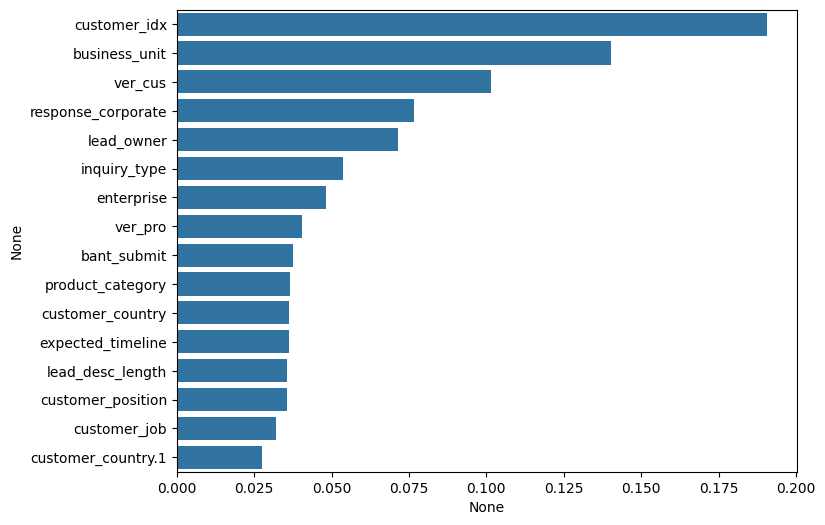

In [15]:
import matplotlib.pyplot as plt # 득점모델 변수 중요도
import seaborn as sns
%matplotlib inline
 
ftr_importances_values = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]
 
plt.figure(figsize=(8, 6))
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()


In [16]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.metrics import f1_score

# XGB 하이퍼 파라미터들 값 지정
def objectiveXGB(trial: Trial, X, y, test):
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 500, 4000),
        'max_depth' : trial.suggest_int('max_depth', 8, 16),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 300),
        'gamma' : trial.suggest_int('gamma', 1, 3),
        'learning_rate' : 0.01,
        'colsample_bytree' : trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1),
        'nthread' : -1,
        # 'tree_method' : 'gpu_hist',
        # 'predictor' : 'gpu_predictor',
        'lambda' : trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha' : trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'subsample' : trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0]),
        'random_state' : 1127
    }
    
    # 학습 모델 생성
    model = XGBClassifier(**param)
    xgb_model = model.fit(X, y, verbose=True) # 학습 진행
    
    # 모델 성능 확인
    score = f1_score(xgb_model.predict(X), y)
    
    return score

In [17]:
# MAE가 최소가 되는 방향으로 학습을 진행
# TPESampler : Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
study = optuna.create_study(direction='maximize', sampler=TPESampler())

# n_trials 지정해주지 않으면, 무한 반복
study.optimize(lambda trial : objectiveXGB(trial, x_train, y_train, x_val), n_trials = 50)

print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

# n_estimators': 3787, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1, 'colsample_bytree': 0.9, 'lambda': 0.018592775351010338, 'alpha': 0.007503184283789436, 'subsample': 0.8


[I 2024-02-09 13:42:33,202] A new study created in memory with name: no-name-73744b91-b138-4994-a22c-f388061b48fd
[I 2024-02-09 13:42:34,563] Trial 0 finished with value: 0.6925919974288928 and parameters: {'n_estimators': 1181, 'max_depth': 15, 'min_child_weight': 221, 'gamma': 3, 'colsample_bytree': 0.8, 'lambda': 0.14239923177597666, 'alpha': 0.1459146594126086, 'subsample': 1.0}. Best is trial 0 with value: 0.6925919974288928.
[I 2024-02-09 13:42:36,621] Trial 1 finished with value: 0.698146655922643 and parameters: {'n_estimators': 1896, 'max_depth': 14, 'min_child_weight': 193, 'gamma': 3, 'colsample_bytree': 1.0, 'lambda': 0.1533934265249342, 'alpha': 0.3437383591656047, 'subsample': 0.8}. Best is trial 1 with value: 0.698146655922643.
[I 2024-02-09 13:42:38,831] Trial 2 finished with value: 0.6867216561539705 and parameters: {'n_estimators': 2435, 'max_depth': 16, 'min_child_weight': 278, 'gamma': 1, 'colsample_bytree': 0.7, 'lambda': 5.3337753166153865, 'alpha': 5.247539503495

Best trial : score 0.9287268770402611, 
params {'n_estimators': 2006, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 1, 'colsample_bytree': 0.5, 'lambda': 0.001149149974385044, 'alpha': 0.004775197939154382, 'subsample': 1.0}


In [20]:
param = {'n_estimators' : 3787, 
                      'max_depth': 14, 
                      'min_child_weight': 1, 
                      'gamma': 1, 
                      'colsample_bytree': 0.9, 
                      'lambda': 0.018592775351010338, 
                      'alpha': 0.007503184283789436, 
                      'subsample': 0.8}

model = XGBClassifier(**param)
x_train = df_train.drop(["is_converted"], axis=1)
model.fit(x_train.fillna(0), df_train['is_converted'])
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted"], axis=1)
test_pred = model.predict(x_test.fillna(0))
sum(test_pred) # True로 예측된 개수

get_clf_eval(y_val, pred)
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

In [18]:
def get_clf_eval(y_test, y_pred=None):

    from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,)

    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

379

In [36]:
len(x_test )

5271